Data Cleaning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

import xgboost as xgb

from scipy.stats import randint

<h1>Data Preprocessing and Scaling</h1>

In [50]:
# Load dataset
dataset = pd.read_csv('Survival_Data.csv')

In [51]:
#Drop undesired features
dataset = dataset.drop(['studyid', 'site', 'strength_comfort_religion', 'petition_prayer_health', 'intercessory_prayers_health'], axis = 1)

In [52]:
# Separate the dataset into numerical and categorical features
numerical_features = dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = dataset.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

In [53]:
# Use median imputation on the numerical features for missing values
dataset[numerical_features] = dataset[numerical_features].fillna(dataset[numerical_features].median())

# Use mode imputation on the categorical features for missing values
for col in categorical_features:
    dataset[col] = dataset[col].fillna(dataset[col].mode().iloc[0])

In [54]:
# Convert binary categorical variables ('Yes'/'No') into 1/0
binary_columns = [col for col in categorical_features if dataset[col].nunique() == 2]
for col in binary_columns:
    unique_values = dataset[col].unique()
    if set(unique_values) == {'Yes', 'No'}:
        dataset[col] = dataset[col].replace({'Yes': 1, 'No': 0})
    elif set(unique_values) == {'Not impaired', 'Impaired'}:
        dataset[col] = dataset[col].replace({'Impaired': 1, 'Not impaired': 0})
    else:
        mapping = {unique_values[0]: 1, unique_values[1]: 0}
        dataset[col] = dataset[col].map(mapping)


# Remaining categorical variables (multi-category)
multi_category_columns = [col for col in categorical_features if col not in binary_columns]

In [55]:
# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(dataset[multi_category_columns])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(multi_category_columns))

In [56]:
# Drop original categorical columns and merge encoded ones
dataset = dataset.drop(multi_category_columns, axis=1)
dataset = pd.concat([dataset, encoded_categorical_df], axis=1)

dataset = dataset.rename(columns={
    'agecat_>=55-<65': 'agecat_55_to_65',
    'agecat_>=65': 'agecat_65_plus'
})

In [57]:
# Separate features and target
X = dataset.drop('died_2_year', axis=1)
y = dataset['died_2_year']

In [58]:
# Scale numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

In [11]:
# Split into Train (80%), Validation (10%), and Test (10%)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

<h3>Model: RandomForest Classifier</h3>

In [12]:
param_dist = {
    'n_estimators': randint(50, 100),
    'max_depth': randint(3, 7),
    'min_samples_leaf': randint(5, 20),
    'min_samples_split': randint(5, 20),
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    random_state=42,
    scoring='accuracy',
    n_jobs=-1
)

# Fit model
random_search.fit(X_train, y_train)

# Get best model based on the params
best_rfc = random_search.best_estimator_

# Evaluate model
train_score = np.mean(cross_val_score(best_rfc, X_train, y_train, cv=5))
val_score = best_rfc.score(X_val, y_val)
test_score = best_rfc.score(X_test, y_test)

# Output results
print("Best Parameters:", random_search.best_params_)
print("Train Score:", train_score)
print("Validation Score:", val_score)
print("Test Score:", test_score)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 17, 'n_estimators': 64}
Train Score: 0.9419591687265403
Validation Score: 0.9710144927536232
Test Score: 0.9420289855072463


In [13]:
y_pred = best_rfc.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       194
           1       1.00      0.08      0.14        13

    accuracy                           0.94       207
   macro avg       0.97      0.54      0.56       207
weighted avg       0.95      0.94      0.92       207



<h3>Model: Neural Network</h3>

In [19]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

In [20]:
# Build Complex Neural Network Model
def build_model():
    model = Sequential()
    
    # Input Layer
    model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Hidden Layers
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile Model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
# Instantiate Model
model = build_model()

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    ],
    verbose=1
)

In [23]:
# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9617 - loss: 0.1469 
Test Accuracy: 0.9565


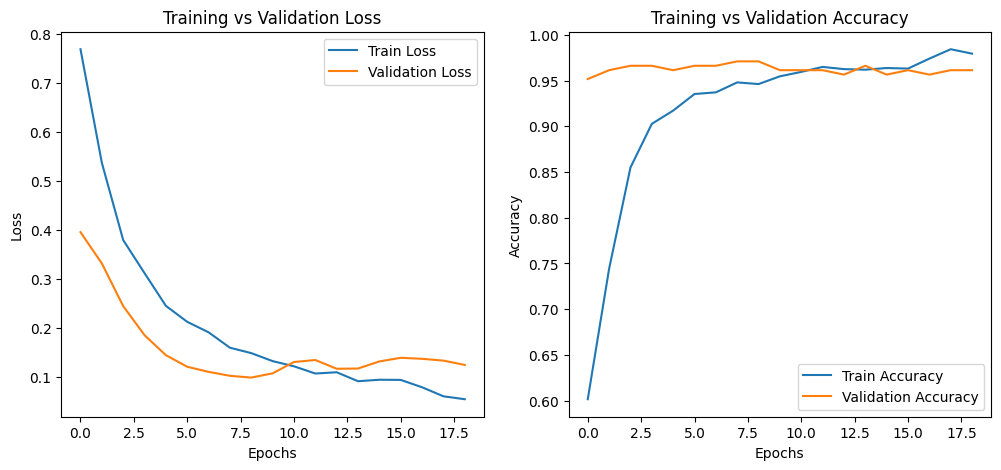

In [24]:
# Plot Loss Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


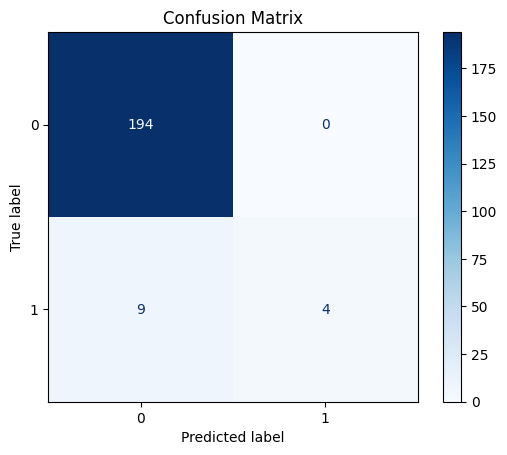

In [25]:
# Predict on test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

<h3>Model: Gradient Boosting Machine</h3>

In [64]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, stratify=y_rest, random_state=42)

In [70]:
base_model = xgb.XGBClassifier(random_state=42, eval_metric="logloss", use_label_encoder=False)

In [71]:
# Define Parameter Grid
param_grid = {
    'n_estimators': [50, 100],  
    'max_depth': [3, 5, 7],            
    'learning_rate': [0.01, 0.1, 0.3], 
    'subsample': [0.6, 0.8, 1.0],      
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 0.5],    
    'reg_lambda': [0.1, 0.5]    
}

# Grid Search with StratifiedKFold (5 Folds)
grid_search = GridSearchCV(
    base_model, param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy', n_jobs=-1, verbose=2
)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Print Best Parameters & Score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 1.0}
Best Cross-Validation Accuracy: 0.9709859928591046


C:\Users\Dalton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:45:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [74]:
# Convert Data to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train Best Model with Early Stopping
params = grid_search.best_params_
params.update({'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42})

evals = [(dtrain, 'train'), (dval, 'val')]
best_xgb = xgb.train(
    params, dtrain,
    num_boost_round=1000,  # Large number, but early stopping will stop it earlier
    evals=evals,
    early_stopping_rounds=10,  # Stop if no improvement after 10 rounds
    verbose_eval=True
)

# Make Predictions
y_pred = (best_xgb.predict(dtest) > 0.5).astype(int)  # Convert probabilities to 0/1
y_pred_proba = best_xgb.predict(dtest)

# Evaluate
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

[0]	train-logloss:0.23708	val-logloss:0.24720
[1]	train-logloss:0.21878	val-logloss:0.23156
[2]	train-logloss:0.20894	val-logloss:0.22513
[3]	train-logloss:0.19582	val-logloss:0.21448
[4]	train-logloss:0.18447	val-logloss:0.20426
[5]	train-logloss:0.17789	val-logloss:0.19965
[6]	train-logloss:0.16909	val-logloss:0.19114
[7]	train-logloss:0.16121	val-logloss:0.18461
[8]	train-logloss:0.15384	val-logloss:0.17810
[9]	train-logloss:0.14744	val-logloss:0.17260
[10]	train-logloss:0.14173	val-logloss:0.16822
[11]	train-logloss:0.13677	val-logloss:0.16364
[12]	train-logloss:0.13240	val-logloss:0.16025
[13]	train-logloss:0.12808	val-logloss:0.15670
[14]	train-logloss:0.12543	val-logloss:0.15478
[15]	train-logloss:0.12176	val-logloss:0.15224
[16]	train-logloss:0.11853	val-logloss:0.14963
[17]	train-logloss:0.11567	val-logloss:0.14880
[18]	train-logloss:0.11305	val-logloss:0.14838
[19]	train-logloss:0.11073	val-logloss:0.14634
[20]	train-logloss:0.10873	val-logloss:0.14482
[21]	train-logloss:0.10

C:\Users\Dalton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:48:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


<h3>Model: Logistic Regression</h3>

In [84]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, stratify=y_rest, random_state=42)

In [86]:
param_grid = {
    'C': [0.1, 1, 3, 5, 10],         # Regularization Strength
    'solver': ['liblinear', 'lbfgs'],  # Solver choice
    'max_iter': [100, 200, 500]        # Iteration limits
}

# Initialize Base Model
base_model = LogisticRegression(penalty='l2', random_state=42)

# Grid Search with Stratified 5-Fold Cross Validation
grid_search = GridSearchCV(
    base_model, param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy', n_jobs=-1, verbose=2
)
grid_search.fit(X_train, y_train)

# Print Best Parameters & Score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}
Best Cross-Validation Accuracy: 0.9564698342946076


In [87]:
# Train Best Model on Full Training Data
best_lr = grid_search.best_estimator_
best_lr.fit(X_train, y_train)

# Evaluate on Validation Set
val_pred = best_lr.predict(X_val)
val_acc = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

# Evaluate on Test Set
test_pred = best_lr.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, test_pred))

Validation Accuracy: 0.9614
Test Accuracy: 0.9710

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       195
           1       1.00      0.50      0.67        12

    accuracy                           0.97       207
   macro avg       0.99      0.75      0.83       207
weighted avg       0.97      0.97      0.97       207



<h3>Model: Support Vector Machine</h3>

In [92]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, stratify=y_rest, random_state=42)

In [93]:
# Define SVC model
svc = SVC(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10], 
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(svc, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [94]:
# Best model from Grid Search
best_svc = grid_search.best_estimator_

# Train Best Model on Training Data
best_svc.fit(X_train, y_train)

# Evaluate on Validation Set
y_val_pred = best_svc.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.5f}")

# Final Test Evaluation
y_test_pred = best_svc.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.5f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.94686
Test Accuracy: 0.96618

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       195
           1       1.00      0.42      0.59        12

    accuracy                           0.97       207
   macro avg       0.98      0.71      0.79       207
weighted avg       0.97      0.97      0.96       207

